In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pymongo import MongoClient

In [2]:
#Data cleaning function
def clean_data(mongo_uri, save_csv=False):
  #Connect to the MongoDB collection and fetch all data
  client = MongoClient(mongo_uri)
  mongo_col = client.capstone.webscraping
  data = mongo_col.find({})
  
  #Parse data into a python list
  houses = [
    (
     house["final_price"],
     house["list_price"],
     house["bedrooms"],
     house["sqft"],
     house["parking"],
     house["type"],
     house["full_address"]
     ) for house in data
  ]
  
  #Create pandas dataframe from the list
  df = pd.DataFrame(houses, columns=["final_price", "list_price", "bedrooms", "sqft", "parking", "type", "full_address"])

  #Clean the data
  df['full_address'] = df['full_address'].str.replace('Property Address:', '')

  df['type'] = df['type'].str.extract(r'(.*)\·')

  df['final_price'] = df['final_price'].str.replace(',','').str.replace('$','')
  df['final_price'] = pd.to_numeric(df['final_price'], errors='coerce')

  df['list_price'] = df['list_price'].str.replace(',','').str.replace('$','')
  df['list_price'] = pd.to_numeric(df['list_price'], errors='coerce')

  df['sqft'] = df['sqft'].str.replace('N/A', '').str.replace(' sqft', '')
  df['min_sqft'] = df['sqft'].str.split("–").str[0]
  df['min_sqft'] = pd.to_numeric(df['min_sqft'], errors='coerce')
  df['max_sqft'] = df['sqft'].str.split("–").str[1]
  df['max_sqft'] = pd.to_numeric(df['max_sqft'], errors='coerce')

  df = df.drop(['sqft'], axis=1)

  #Drop all duplicates
  df = df.drop_duplicates()

  #Drop all Null Values
  df = df.dropna().reset_index(drop = True)
  
  #Save the dataframe as a csv if the user set save_csv = True
  if save_csv:
    df.to_csv('data_cleaned.csv', index=False)
  
  #Function return the cleaned dataframe 
  return df

In [3]:
mongo_uri = ""
df = clean_data(mongo_uri=mongo_uri, save_csv=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [4]:
#Load Dataset
df.head()

,final_price,list_price,bedrooms,parking,type,full_address,min_sqft,max_sqft
0,825000,845000,2,1,Condo,"1102 - 99 Harbour Sq, Toronto, Ontario",900.0,999.0
1,567000,569000,2,1,Condo,"812 - 18 Valley Woods Rd, Toronto, Ontario",600.0,699.0
2,512500,545000,1,1,Condo,"512 - 7 Concorde Pl, Toronto, Ontario",600.0,699.0
3,1300000,1088000,6,2,House,"27 Granby St, Toronto, Ontario",2000.0,2500.0
4,599900,599900,2,1,Condo,"708 - 1461 Lawrence Ave, Toronto, Ontario",600.0,699.0


In [5]:
df.dtypes

final_price       int64
list_price        int64
bedrooms         object
parking          object
type             object
full_address     object
min_sqft        float64
max_sqft        float64
dtype: object

In [6]:
df['bedrooms'] = df['bedrooms'].astype('int')
df['parking'] = df['parking'].astype('float')

In [7]:
#Key stats
df.describe()

,final_price,list_price,bedrooms,parking,min_sqft,max_sqft
count,1.016000e+03,1.016000e+03,1016.000000,1016.000000,1016.000000,1016.000000
mean,9.431067e+05,9.577496e+05,1.932087,2.422244,998.622047,1198.981299
std,5.981039e+05,6.229392e+05,0.956345,34.842840,562.395537,723.186422
min,2.600000e+05,3.297000e+05,0.000000,0.000000,500.000000,599.000000
25%,6.200000e+05,6.100000e+05,1.000000,1.000000,600.000000,699.000000
50%,7.499440e+05,7.499000e+05,2.000000,1.000000,800.000000,899.000000
75%,9.950000e+05,9.990000e+05,2.000000,1.000000,1200.000000,1399.000000
max,5.660000e+06,5.750000e+06,6.000000,1111.000000,4250.000000,5000.000000


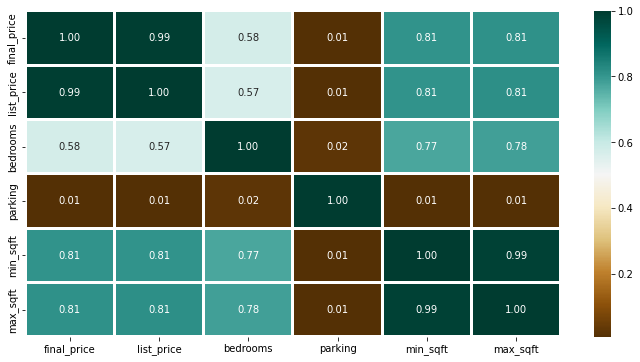

In [8]:
#Correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(),
            cmap = 'BrBG',
            fmt = '.3f',
            linewidths = 2,
            annot = True)

In [9]:
#!pip install -U pandas-profiling

In [10]:
# #Create Profile Report
 
# #Importing package
# import pandas_profiling as pp
# from IPython.display import IFrame
 
# # Profile Report
# report = pp.ProfileReport(df)
# report.to_file('report.html')
# display(IFrame('report.html', width=900, height=350))

In [11]:
#Create One Hot Encoded Dataframe

from sklearn.preprocessing import OneHotEncoder

data = df.drop(['full_address'], axis=1)

ohe = OneHotEncoder(drop='first')

data_object = data.select_dtypes('object')
ohe.fit(data_object)

codes = ohe.transform(data_object).toarray()
feature_names = ohe.get_feature_names_out(data_object.columns)

data_ohe = pd.concat([data.select_dtypes(exclude='object'), 
               pd.DataFrame(codes,columns=feature_names).astype(int)], axis=1)

data_ohe.head()

,final_price,list_price,bedrooms,parking,min_sqft,max_sqft,type_House,type_Townhouse
0,825000,845000,2,1.0,900.0,999.0,0,0
1,567000,569000,2,1.0,600.0,699.0,0,0
2,512500,545000,1,1.0,600.0,699.0,0,0
3,1300000,1088000,6,2.0,2000.0,2500.0,1,0
4,599900,599900,2,1.0,600.0,699.0,0,0


In [12]:
#Tukey Method

# Import required libraries
from collections import Counter

# Outlier detection 
def detect_outliers(df,n,features):
    
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# List of Outliers
outliers_to_drop = detect_outliers(data_ohe.drop('final_price',axis=1),0,list(data_ohe.drop('final_price',axis=1)))
final_data = data_ohe.drop(data_ohe.index[outliers_to_drop]).reset_index(drop = True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   final_price      563 non-null    int64  
 1   list_price       563 non-null    int64  
 2   bedrooms         563 non-null    int64  
 3   parking          563 non-null    float64
 4   min_sqft         563 non-null    float64
 5   max_sqft         563 non-null    float64
 6   type_House       563 non-null    int64  
 7   type_Townhouse   563 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 35.3 KB


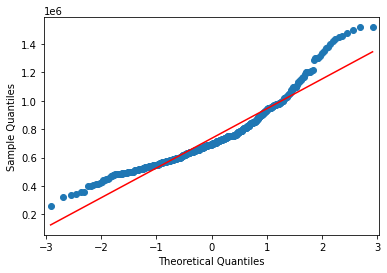

In [13]:
#Create Q-Q Plot
from statsmodels.graphics.gofplots import qqplot
import pylab
qqplot(final_data['final_price'],line='s')
pylab.show()

In [24]:
#Normality test - Shapiro-Wilk Test

#   p <= alpha(0.05): reject H0, not normal.
#   p > alpha(0.05): fail to reject H0, normal.

from scipy.stats import shapiro
stat, p = shapiro(final_data['final_price'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.921, p=0.000
Sample does not look Gaussian (reject H0)


In [15]:
#Define x and y variable
x = final_data.drop(['final_price'],axis=1).to_numpy()
y = final_data['final_price'].to_numpy()

#Create Train and Test Datasets
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

#Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [16]:
#Create Standard Model - using Dummy Variables

from sklearn import metrics

for name,method in [('Linear regression', LinearRegression())]: 
    method.fit(x_train2,y_train)
    predict = method.predict(x_test2)

print('\n Regression Model - using OneHotEncoder')
print('\nMethod: {}'.format(name))   

#Coefficents
print('\nIntercept: {:.2f}'.format(float(method.intercept_)))
coeff_table=pd.DataFrame(np.transpose(method.coef_),
                         final_data.drop(['final_price'],axis=1).columns,
                         columns=['Coefficients'])
print(coeff_table)
    
#R2,MAE,MSE and RMSE
print('\nR2: {:.2f}'.format(metrics.r2_score(y_test,predict)))
adjusted_r_squared = 1-(1-metrics.r2_score(y_test,predict))*(len(y)-1)/(len(y)-x.shape[1]-1)
print('Adj_R2: {:0.2f}'.format(adjusted_r_squared))
print('Mean Absolute Error: {:.2f}'.format(metrics.mean_absolute_error(y_test, predict)))  
print('Mean Squared Error: {:.2f}'.format(metrics.mean_squared_error(y_test, predict)))  
print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, predict)))) 

In [17]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_lm = Pipeline([('scl', StandardScaler()),
                    ('clf', LinearRegression())])
pipeline.insert(0,pipe_lm)

pipe_lasso= Pipeline([('scl', StandardScaler()),
                     ('clf', Lasso(random_state=100))])
pipeline.insert(1,pipe_lasso)

pipe_ridge= Pipeline([('scl', StandardScaler()),
                     ('clf', Ridge(random_state=100))])
pipeline.insert(2,pipe_ridge)

pipe_elas= Pipeline([('scl', StandardScaler()),
                     ('clf', ElasticNet(random_state=100))])
pipeline.insert(3,pipe_elas)

# Set grid search params 

modelpara =[]

param_gridlm = {}
modelpara.insert(0,param_gridlm)

param_gridlasso = {'clf__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1e-1, 1, 5, 10, 20],
                  'clf__tol':[1e-1, 1, 5, 10, 20, 50, 100]}
modelpara.insert(1,param_gridlasso)

param_gridridge = {'clf__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1e-1, 1, 5, 10, 20],
                  'clf__tol':[1e-1, 1, 5, 10, 20, 50, 100]}
modelpara.insert(2,param_gridridge)

param_gridelas = {'clf__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1e-1, 1, 5, 10, 20],
                 'clf__tol':[1e-1, 1, 5, 10, 20, 50, 100]}
modelpara.insert(3,param_gridelas)

In [18]:
#Create Learning Curves

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train2, 
                                                            y=y_train,
                                                            train_sizes=np.linspace(.1,1,10),
                                                            scoring = 'neg_root_mean_squared_error',
                                                            cv=10,random_state=100)
    
    train_mean = np.sqrt(np.mean(-train_scores, axis=1))
    train_std = np.sqrt(np.std(-train_scores, axis=1))
    test_mean = np.sqrt(np.mean(-test_scores, axis=1))
    test_std = np.sqrt(np.std(-test_scores, axis=1))
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('RMSE')
    plt.legend(loc='best')
    plt.ylim([0,500])
    plt.show()

Learning Curve - LM


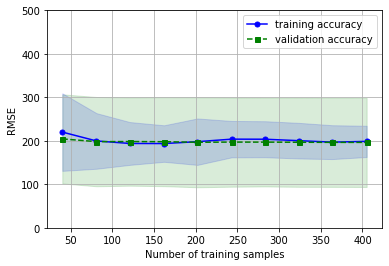

Learning Curve - Lasso


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.688e+08, tolerance: 1.900e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.688e+08, tolerance: 1.900e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

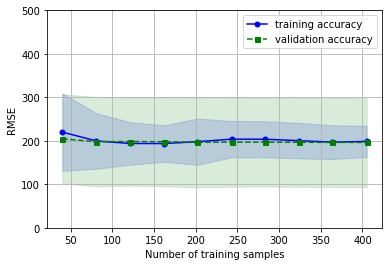

Learning Curve - Ridge


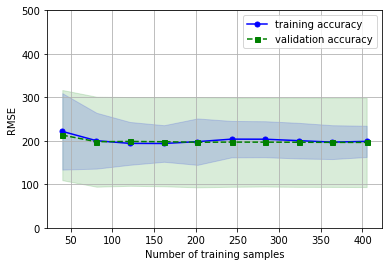

Learning Curve - ElasticNet


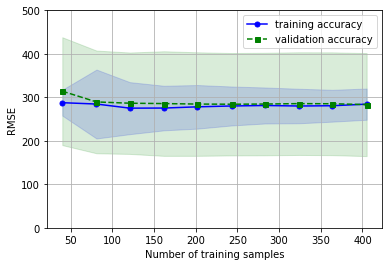

In [19]:
#Plot Learning Curve

print('Learning Curve - LM')
plot_learning_curves(pipe_lm)
print('Learning Curve - Lasso')
plot_learning_curves(pipe_lasso)
print('Learning Curve - Ridge')
plot_learning_curves(pipe_ridge)
print('Learning Curve - ElasticNet')
plot_learning_curves(pipe_elas)

Model Evaluation - RMSE Score
LinearRegression 198.11
Lasso 198.11
Ridge 198.07
ElasticNet 284.29




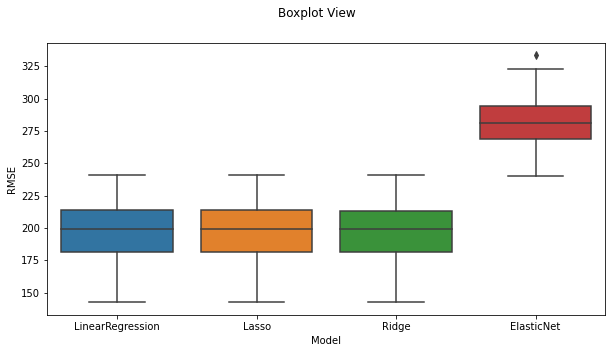

In [20]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('LinearRegression',pipe_lm))
models.append(('Lasso',pipe_lasso))
models.append(('Ridge',pipe_ridge))
models.append(('ElasticNet',pipe_elas))
  
#Model Evaluation
results =[]
names=[]
scoring ='neg_root_mean_squared_error'
print('Model Evaluation - RMSE Score')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train2,y_train,cv=rkf,scoring=scoring)
    results.append(np.sqrt(-cv_results))
    names.append(name)
    print('{} {:.2f}'.format(name,np.sqrt(-cv_results.mean())))
print('\n')

#Boxplot View
fig = plt.figure(figsize=(10,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.show()

In [21]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn import metrics

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='neg_root_mean_squared_error')
    gs_clf = gs_clf.fit(x_train2, y_train)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test2)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
   
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    print('\nBest Parameters:',bestpara)
    
    #Test data accuracy of model with best params    
    print('\nIntercept: {:.2f}'.format(float(gs_clf.best_estimator_.named_steps['clf'].intercept_)))
    coeff_table=pd.DataFrame(np.transpose(gs_clf.best_estimator_.named_steps['clf'].coef_),
                             final_data.drop('final_price',axis=1).columns,
                              columns=['Coefficients'])
    print('\n')
    print(coeff_table)
    
    #Print R2
    print('\nR2: {:0.2f}'.format(metrics.r2_score(y_test,y_pred)))
    adjusted_r_squared2 = 1-(1-metrics.r2_score(y_test,y_pred))*(len(y)-1)/(len(y)-x.shape[1]-1)
    print('Adj_R2: {:0.2f}'.format(adjusted_r_squared2))

    #Print MSE and RMSE
    print('Mean Absolute Error: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_pred)))  
    print('Mean Squared Error: {:.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))  
    print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))) 

In [22]:
#Run Models
for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)


Optimized Model

Model Name: LinearRegression()

Best Parameters: {}

Intercept: 737563.25


                 Coefficients
list_price       2.094640e+05
bedrooms         8.800881e+02
parking         -4.320100e-12
min_sqft         2.348522e+03
max_sqft        -3.118970e+03
type_House       0.000000e+00
type_Townhouse   0.000000e+00

R2: 0.97
Adj_R2: 0.97
Mean Absolute Error: 21856.56
Mean Squared Error: 1114851133.64
Root Mean Squared Error: 33389.39

Optimized Model

Model Name: Lasso(random_state=100)

Best Parameters: {'clf__alpha': 20, 'clf__tol': 5}

Intercept: 737563.25


                  Coefficients
list_price       209467.924794
bedrooms            359.966855
parking               0.000000
min_sqft           -387.105032
max_sqft            -31.224952
type_House            0.000000
type_Townhouse        0.000000

R2: 0.97
Adj_R2: 0.97
Mean Absolute Error: 21885.17
Mean Squared Error: 1112576175.59
Root Mean Squared Error: 33355.30


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.78435e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.72795e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.72942e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.70832e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit


Optimized Model

Model Name: Ridge(random_state=100)

Best Parameters: {'clf__alpha': 1, 'clf__tol': 0.1}

Intercept: 737563.25


                  Coefficients
list_price       208804.000467
bedrooms           1032.983162
parking               0.000000
min_sqft           1672.433820
max_sqft          -2200.591581
type_House            0.000000
type_Townhouse        0.000000

R2: 0.97
Adj_R2: 0.97
Mean Absolute Error: 21878.25
Mean Squared Error: 1109598194.11
Root Mean Squared Error: 33310.63

Optimized Model

Model Name: ElasticNet(random_state=100)

Best Parameters: {'clf__alpha': 1e-15, 'clf__tol': 5}

Intercept: 737563.25


                  Coefficients
list_price       209487.924794
bedrooms            370.502964
parking               0.000000
min_sqft           -424.654141
max_sqft            -31.267923
type_House            0.000000
type_Townhouse        0.000000

R2: 0.97
Adj_R2: 0.97
Mean Absolute Error: 21886.27
Mean Squared Error: 1112765874.16
Root Mean Squared Error: 33